# import

In [ ]:
import pandas as pd
import json
import requests
from pathlib import Path
import numpy as np
import sys
import requests
import json
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline


# directories


In [36]:
if sys.platform =='linux':
    path_d = Path('/mnt/d')
else:
    path_d = Path('D://')
data_dir = path_d/'data'/'dpe'/'upload'    

plot_dir = Path('.')/'plot'
plot_dir.mkdir(exist_ok=True,parents=True)

In [3]:
useless_cols = ['type_vitrage_verriere','nombre_entrees_avec_sas','nombre_entrees_sans_sas'] 

# analyse des métadonnées de dépot dans la base

In [34]:
    dpe_table = pd.read_csv(td001_dpe_file,sep=',',error_bad_lines=False,dtype=str,index_col=0)


In [51]:
useful_cols = ['date_reception_dpe','date_etablissement_dpe','date_visite_diagnostiqueur','nom_methode_dpe', 'version_methode_dpe',
       'nom_methode_etude_thermique',
               'organisme_certificateur','dpe_vierge','classe_consommation_energie','numero_dpe',
              'tr002_type_batiment_id']

dept_dict = dict()
for td001_dpe_file in data_dir.iterdir():
    dept = td001_dpe_file.name.split('-')[1].zfill(2)
    dpe_table = pd.read_csv(td001_dpe_file,sep=',',error_bad_lines=False,dtype=str,index_col=0)
    cols = [col for col in dpe_table if col in useful_cols]
    dpe_table = dpe_table.sort_values('date_reception_dpe').drop_duplicates('numero_dpe',keep='last')
    dept_dict[dept] = dpe_table[cols]
    

## dates

In [56]:
date_dict = dict()
for date in ['date_reception_dpe','date_etablissement_dpe','date_visite_diagnostiqueur']:

    s_date=pd.Series()

    for dpe_table in dept_dict.values():
        s=pd.Series(index=dpe_table[date])
        s[:]=1
        s_date=s_date.append(s)
        
    s_date=s_date[s_date.index>'2000-01-01']
    s_date=s_date[s_date.index<'2021-01-01']
    s_date.index = pd.to_datetime(s_date.index)
    
    date_dict[date]=s_date

/home/toto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/home/toto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [67]:
mean_delays = dict()
for date,s_date in date_dict.items():
    mean_delays[date]=s_date.index.mean()

In [74]:
pd.Series(mean_delays).sort_values().diff()

date_visite_diagnostiqueur                      NaT
date_etablissement_dpe       8 days 18:20:08.197900
date_reception_dpe           7 days 12:03:48.930460
dtype: timedelta64[ns]

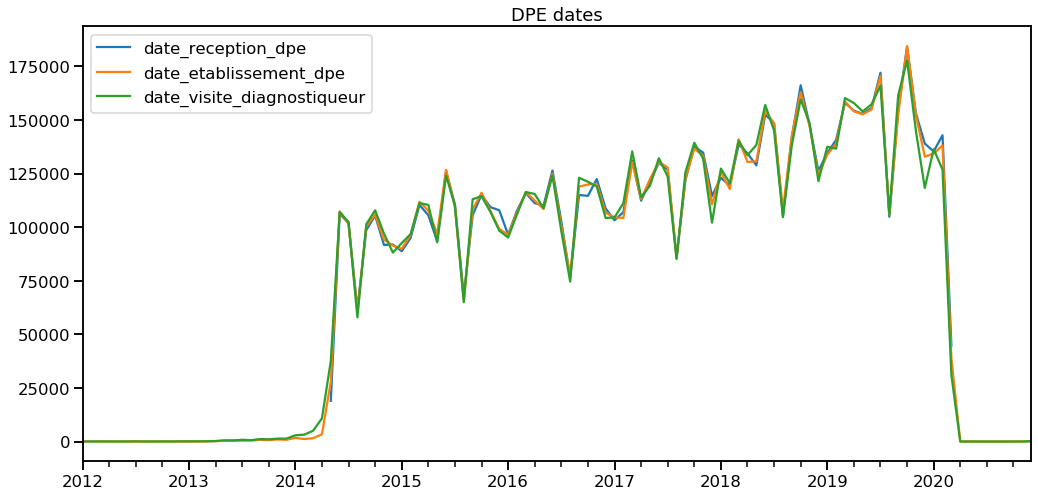

In [93]:
for date,s_date in date_dict.items():
    ax=s_date['2012':'2020'].resample('MS').sum().plot(figsize=(17,8),label = date)
plt.legend()
ax.set_title('DPE dates')
plt.savefig(str(plot_dir/'dates.png'),bbox_inches='tight')


## organismes certificateurs

In [96]:
s_org = pd.Series()
for dpe_table in dept_dict.values():
    s_org = s_org.append(dpe_table.organisme_certificateur)

/home/toto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [102]:
s_org=s_org.str.upper()

In [103]:
s_org.value_counts().head(10)

ICERT                                  1103908
BUREAU VERITAS CERTIFICATION            636796
I.CERT                                  622171
QUALIXPERT                              446101
AFNOR CERTIFICATION                     406026
GINGER CATED                            372400
BUREAU VERITAS CERTIFICATION FRANCE     274063
DEKRA CERTIFICATION                     258177
SOCOTEC CERTIFICATION                   249519
ABCIDIA CERTIFICATION                   240279
dtype: int64